# RLbook2020-2.8 Gradient Bandit Algorithms



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



Bad key text.latex.preview in file C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You pr

## 函数改造

基于RLbook-2.7-Upper-Confidence-Bound中的k_armed_bandit_one_run()进行改造。

(1) 追加一个函数softmax()--应该能比如说scikit-learn等库中找到，不过嘛，自己写一个也是一个练习

(2) 追加参数actsel='SGD'的选项

(3) 在actsel设定为'SGD'时，调用softmax()以更新各行动的H(preference)值

(4) 追加baseline参数用于当actsel=SGD时，选择有baseline还是没有baseline

In [7]:
print(-10000 > -np.Inf)
print(np.log(2.78))

True
1.0224509277025455


In [4]:
np.random.randint(10)

4

In [5]:
# generating random samples with probabilities
print(np.random.choice([k for k in range(4)], size=10,replace=True, p=[0.3, 0.5, 0.0, 0.2]))

[1 0 3 1 3 1 1 1 3 3]


In [49]:
def softmax(H):
    """
    Input:
        H: Preference input
    Output:
        P: Probability
    """
    L = len(H)
    H_exp = np.exp(H)
    P = H_exp / np.sum(H_exp)
    
    if not np.isclose(np.sum(P), 1): # The sum of probability should be one.
        print('softmax(): error!')
    
    return P

In [67]:
a = np.random.randint(10, size=10)
print(softmax(a))

[6.82214426e-03 1.24951931e-04 3.72476456e-01 5.04092067e-02
 1.37026431e-01 3.72476456e-01 5.04092067e-02 9.23276826e-04
 6.82214426e-03 2.50972662e-03]


In [68]:
print(a)
print(a[:-1])

[4 0 8 6 7 8 6 2 4 3]
[4 0 8 6 7 8 6 2 4]


In [103]:
def k_armed_bandit_one_run(qstar,epsilon,nStep,Qinit,QUpdtAlgo='sample_average',alpha=0, stationary=True, actsel=None, baseline=True):
    """
    One run of K-armed bandit simulation.
    Add Qinit to the interface.
    Input:
        qstar:     Mean reward for each candition actions
        epsilon:   Epsilon value for epsilon-greedy algorithm
        nStep:     The number of steps for simulation
        Qinit:     Initial setting for action-value estimate
        QUpdtAlgo: The algorithm for updating Q value--'sample_average','exp_decaying'
        alpha:     step-size in case of 'exp_decaying' and also used in case of actsel='SGD'
        actsel:    Specifying action selection algorithm
        baseline:  'Yes','No' for actsel=SGD
    Output:
        a[t]: action series for each step in one run
        r[t]: reward series for each step in one run
        Q[k]: reward sample average up to t-1 for action[k]
        aNum[k]: The number of being selected for action[k]
        optRatio[t]: Ration of optimal action being selected over tim
    """                    
    K     = len(qstar)
    Q     = Qinit
    a     = np.zeros(nStep+1,dtype='int') # Item#0 for initialization
    aNum  = np.zeros(K,dtype='int')       # Record the number of action#k being selected
    
    H     = np.zeros(K,dtype='int')       # Record the preference of all actions, and initialized to all zeros, for Gradient algorithm
    P     = softmax(H)
    r     = np.zeros(nStep+1)             # Record the award received at each time step. r[0] for initialization

    average_reward = 0                    # Used for SGD action selection algorithm. Note the difference bwteen this and Q!
    
    if stationary == False:
        qstar = np.ones(K)/K              # qstart initialized to 1/K for all K actions    
    
    optCnt   = 0
    optRatio = np.zeros(nStep+1,dtype='float') # Item#0 for initialization

    for t in range(1,nStep+1):

        #0. For non-stationary environment, optAct also changes over time.Hence, move to inside the loop.
        optAct   = np.argmax(qstar)
                
        #1. action selection
        if actsel == 'UCB':
            aMax = -np.Inf            
            for k in range(K):
                if aNum[k] == 0:
                    aMetric = np.inf
                else:
                    aMetric = Q[k] + epsilon * np.sqrt(np.log(t)/aNum[k])
                if aMax < aMetric:
                    aOpt = k
                    aMax = aMetric
            a[t] = aOpt                                
        elif actsel == 'SGD':            
            # Calculate the probability of all actions based on the H preference
            P     = softmax(H)
            # Choose the action based on the probability
            a[t] = np.random.choice([k for k in range(K)], size=1,replace=True, p=P)            
        else:
            tmp = np.random.uniform(0,1)
            if tmp < epsilon: # random selection
                a[t] = np.random.choice(np.arange(K))
                #print('random selection: a[{0}] = {1}'.format(t,a[t]))
            else:             # greedy selection
                #选择Q值最大的那个，当多个Q值并列第一时，从中任选一个--但是如何判断有多个并列第一的呢？
                #对Q进行random permutation处理后再找最大值可以等价地解决这个问题
                p = np.random.permutation(K)
                a[t] = p[np.argmax(Q[p])]
                #print('greedy selection: a[{0}] = {1}'.format(t,a[t]))

        aNum[a[t]] = aNum[a[t]] + 1

        #2. reward: draw from the pre-defined probability distribution    
        r[t] = np.random.randn() + qstar[a[t]]        

        #3.Update Q of the selected action - #2.4 Incremental Implementation
        # Q[a[t]] = (Q[a[t]]*(aNum[a[t]]-1) + r[t])/aNum[a[t]]    
        if QUpdtAlgo == 'sample_average':
            Q[a[t]] = Q[a[t]] + (r[t]-Q[a[t]])/aNum[a[t]]    
        elif QUpdtAlgo == 'exp_decaying':
            Q[a[t]] = Q[a[t]] + (r[t]-Q[a[t]])*alpha
        
        #4. Optimal Action Ratio tracking
        #print(a[t], optAct)
        if a[t] == optAct:
            optCnt = optCnt + 1
        optRatio[t] = optCnt/t

        #5. Random walk of qstar simulating non-stationary environment
        # Take independent random walks (say by adding a normally distributed increment with mean 0
        # and standard deviation 0.01 to all the q*(a) on each step).   
        if stationary == False:
            qstar = qstar + np.random.randn(K)*0.01 # Standard Deviation = 0.01
            #print('t={0}, qstar={1}, sum={2}'.format(t,qstar,np.sum(qstar)))

        #6. Update H preference
        H_At_old = H[a[t]] # backoff for later use
        H = H - alpha*(r[t]-average_reward)*P
        H[a[t]] = H_At_old + alpha*(r[t]-average_reward)*(1-P[a[t]])

        #7. Update average_reward
        if baseline:
            #average_reward += (r[t] - average_reward)/t
            average_reward = np.mean(r[1:]) # NG, but why?
        
    return a,aNum,r,Q,optRatio

## Test with Gradient Bandit Algorithm

(1) Action selction: soft-max with SGD

(2) alpha = 0.1

(2) qstar: true expected rewards are selected according to a normal distribution with a mean of +4 instead of zero (and with unit variance as before).

(3) QUpdtAlgo='sample_average', by default.

(3) Environment: stationary

Text(0.5, 1.0, 'qstar vs aNum')

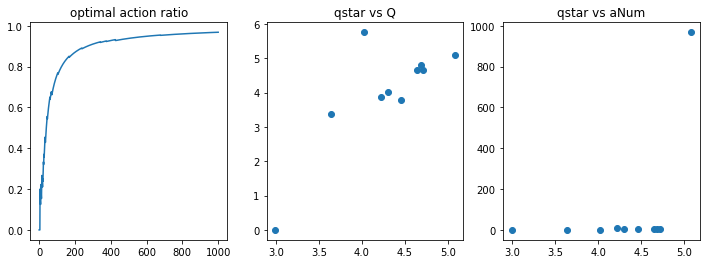

In [97]:
nStep = 1000
epsilon = 0.1
K       = 10
qstar   = np.random.randn(K) + 4
Qinit   = np.zeros(K)
a,aNum,r,Q,optRatio = k_armed_bandit_one_run(qstar,epsilon,nStep, Qinit, alpha = 0.1, actsel='SGD',baseline=True)
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(optRatio)
ax[1].scatter(qstar,Q)
ax[2].scatter(qstar,aNum)
ax[0].set_title('optimal action ratio')
ax[1].set_title('qstar vs Q')
ax[2].set_title('qstar vs aNum')

## Experiment Comparison among the following four cases

SGD, stationary environment,
(1) alpha = 0.1, with baseline
(2) alpha = 0.1, without baseline
(3) alpha = 0.4, with baseline
(4) alpha = 0.4, without baseline


....................................................................................................run =  100
....................................................................................................run =  200
....................................................................................................run =  300
....................................................................................................run =  400
....................................................................................................run =  500
....................................................................................................run =  600
....................................................................................................run =  700
....................................................................................................run =  800
....................................................................................................run =  900
.

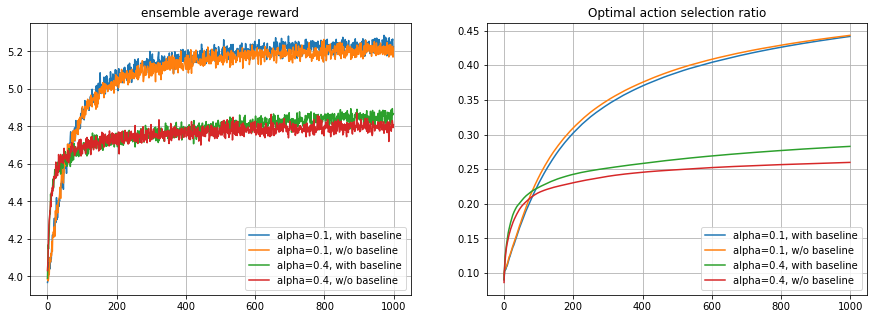

In [104]:
nStep = 1000
nRun  = 2000
K     = 10

r_1   = np.zeros((nRun,nStep+1))
r_2   = np.zeros((nRun,nStep+1))
r_3   = np.zeros((nRun,nStep+1))
r_4   = np.zeros((nRun,nStep+1))
optRatio_1 = np.zeros((nRun,nStep+1))
optRatio_2 = np.zeros((nRun,nStep+1))
optRatio_3 = np.zeros((nRun,nStep+1))
optRatio_4 = np.zeros((nRun,nStep+1))

Qinit = np.zeros(K)
epsilon = 0

for run in range(nRun):
    print('.',end='')
    if run%100==99:        
        print('run = ',run+1)
    
    qstar   = np.random.randn(10) + 4         
    a,aNum,r_1[run,:],Q,optRatio_1[run,:] = k_armed_bandit_one_run(qstar,epsilon,nStep,Qinit, alpha=0.1,actsel='SGD',baseline=True)
    a,aNum,r_2[run,:],Q,optRatio_2[run,:] = k_armed_bandit_one_run(qstar,epsilon,nStep,Qinit, alpha=0.1,actsel='SGD',baseline=False)
    a,aNum,r_3[run,:],Q,optRatio_3[run,:] = k_armed_bandit_one_run(qstar,epsilon,nStep,Qinit, alpha=0.4,actsel='SGD',baseline=True)
    a,aNum,r_4[run,:],Q,optRatio_4[run,:] = k_armed_bandit_one_run(qstar,epsilon,nStep,Qinit, alpha=0.4,actsel='SGD',baseline=False)   

    
# Plotting    
rEnsembleMean_1 = np.mean(r_1,axis=0)
rEnsembleMean_2 = np.mean(r_2,axis=0)
rEnsembleMean_3 = np.mean(r_3,axis=0)
rEnsembleMean_4 = np.mean(r_4,axis=0)

optRatioEnsembleMean_1 = np.mean(optRatio_1,axis=0)
optRatioEnsembleMean_2 = np.mean(optRatio_2,axis=0)
optRatioEnsembleMean_3 = np.mean(optRatio_3,axis=0)
optRatioEnsembleMean_4 = np.mean(optRatio_4,axis=0)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(rEnsembleMean_1[1:])  # Note: t count from 1 in k_armed_bandit_one_run()
ax[0].plot(rEnsembleMean_2[1:])
ax[0].plot(rEnsembleMean_3[1:])
ax[0].plot(rEnsembleMean_4[1:])
ax[0].legend(['alpha=0.1, with baseline','alpha=0.1, w/o baseline','alpha=0.4, with baseline','alpha=0.4, w/o baseline'])
ax[0].set_title('ensemble average reward')
ax[0].grid()

ax[1].plot(optRatioEnsembleMean_1[1:])
ax[1].plot(optRatioEnsembleMean_2[1:])
ax[1].plot(optRatioEnsembleMean_3[1:])
ax[1].plot(optRatioEnsembleMean_4[1:])
ax[1].legend(['alpha=0.1, with baseline','alpha=0.1, w/o baseline','alpha=0.4, with baseline','alpha=0.4, w/o baseline'])
ax[1].set_title('Optimal action selection ratio')
ax[1].grid()
